# **Identification of shear at yielding from normal stress components**

# Tensor formulation

In [51]:
%matplotlib widget
import sympy as sp
import numpy as np
import matplotlib.pylab as plt
sp.init_printing()

To simplify orientation, a the components of a general 2D stress tensor are introduced as follows

\begin{align}
\sigma_{ij} = 
\left[
\begin{array}{cc}
\sigma_{xx} & \sigma_{xy} \\
\sigma_{yx} & \sigma_{yy}
\end{array}
\right] =
\left[
\begin{array}{cc}
\sigma_{x} & \tau \\
\tau & \sigma_{y}
\end{array}
\right]
\end{align}

The global stress components $\sigma_x$ and $\sigma_y$ are given based on the equilibrium conditions at the cross sectional level. The shear stress $\tau^\mathrm{fps}$ can be calculated either using a cross-sectional equilibrium or based on the compression-tension yield envelope. 

In [52]:
tau_fps, sigma_x, sigma_y = sp.symbols(r'tau, sigma_x, sigma_y')
sigma_1, sigma_2 = sp.symbols(r'sigma_1, sigma_2')
f_ct, f_cm = sp.symbols(r'f_ct, f_cm', nonnegative=True)

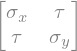

In [53]:
sigma_xy = sp.Matrix([[sigma_x, tau_fps],
                     [tau_fps, sigma_y]])
sigma_xy

In [54]:
params = (sigma_x, sigma_y, f_ct, f_cm)

The principal stress tensor is introduced as
\begin{align}
\sigma_{12} =
\left[
\begin{array}{cc}
\sigma_1 & 0 \\
0 & \sigma_2
\end{array}
\right]
\end{align}

In [55]:
sigma_12 = sp.Matrix([[sigma_1, 0],
                      [0, sigma_2]])

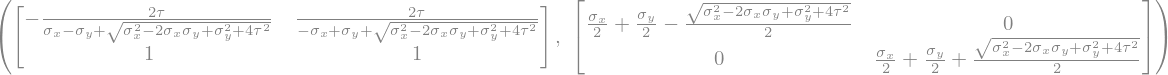

In [56]:
P_xy, D_xy = sigma_xy.diagonalize()
P_xy, D_xy

In [57]:
sigma_1_xy = D_xy[0,0]
sigma_2_xy = D_xy[1,1]

The orientation of principal stresses

## Kupfer envelope on combined tension and compression

A linear transition between the tensile and compressive strength is assumed
$$
\displaystyle \frac{\sigma_{2}}{f_{ct}} - \frac{4 \sigma_{1}}{5 f_{cm}} = 1
$$
where $\sigma_1$ is representing the compressive strength and $\sigma_2$ represents the tensile stress. 

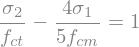

In [58]:
Kupfer_ct = sp.Eq(sigma_2 / f_ct - sp.Rational(8,10) * sigma_1 / f_cm, 1)
Kupfer_ct

The tensile stress $\sigma_2$ can be resolved as
$$
\sigma_2 = \displaystyle f_{\mathrm{ct}} \left( 1 + \frac{4 \sigma_{1}}{5 f_{\mathrm{cm}}} \right)
$$

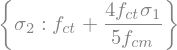

In [59]:
sigma_2_ct_solved = sp.solve(Kupfer_ct, sigma_2)[0]
{sigma_2: sigma_2_ct_solved}

Verify the shape of the yield limit by plotting $\sigma_2$ in the range of $\sigma_1 \in (-f_\mathrm{cc}, f_\mathrm{ct})$. Note that the line intersects the horizontal axis at the value of 37.5. The nonlinear part of the Kupfer function is not considered yet.

In [60]:
get_sigma_2_ct_solved = sp.lambdify((sigma_1, f_ct, f_cm), sigma_2_ct_solved, "numpy")
fig, ax = plt.subplots(1,1)
fig.canvas.header_visible=False
sigma_1_range = np.linspace(-40,5,100)
ax.plot(sigma_1_range, get_sigma_2_ct_solved(sigma_1_range, 3, 30))
ax.set_xlabel(r'$\sigma_1$'); ax.set_ylabel(r'$\sigma_2$');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Let us now require that $\sigma_2$ constrained by the Kupfer condition be equal to the 
second principal stress component expressed in terms of the global stress components $\sigma_x, \sigma_y, \tau$

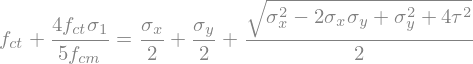

In [61]:
sig_2_ct_eq = sp.Eq(sigma_2_ct_solved, sigma_2_xy)
sig_2_ct_eq

and substitute the first principal stress component $\sigma_1(\sigma_x, \sigma_y, \tau)$ to obtain

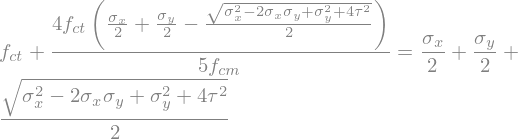

In [62]:
sig_2_ct_eq_xy = sig_2_ct_eq.subs(sigma_1, sigma_1_xy)
sig_2_ct_eq_xy

Using this equation, the global shear stress component inducing yielding can be expressed in terms of the global stress components $\sigma_x, \sigma_y$

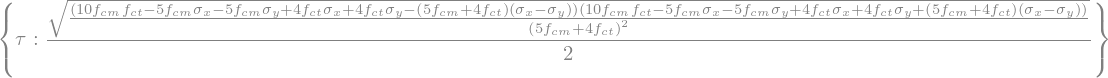

In [63]:
tau_fps_ct_solved = sp.solve(sig_2_ct_eq_xy, tau_fps)[0]
{tau_fps : sp.simplify(tau_fps_ct_solved)}

The orientation of the principle axes can then be obtained as

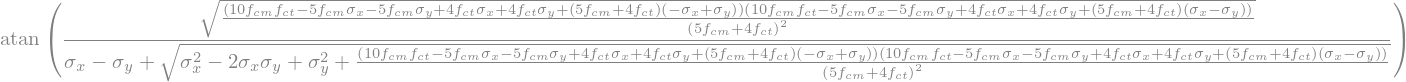

In [64]:
theta = sp.atan( sp.simplify(-P_xy[0,0] / P_xy[1,0])).subs(tau_fps, tau_fps_ct_solved)
theta

# Symbolic verification

To verify the solution, let us study two limit cases

## Verification 1: Test the solution for zero $\tau$

Using the obtained $\tau$ at yielding, we can pose the question: What is the link between $\sigma_y$ and $\sigma_x$ if $\tau = 0$.
$$
\tau(\sigma_x, \sigma_y) = 0 \; \implies \; \left. \sigma_y(\sigma_x) \right|_{\tau=0}
$$

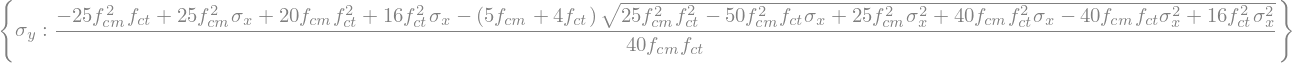

In [15]:
sigma_y_ct_at_tau_zero = sp.solve(tau_fps_ct_solved, sigma_y)[0]
{sigma_y : sp.simplify(sigma_y_ct_at_tau_zero)}

Given the parameters $\sigma_x = 0, f_\mathrm{ct} = 3, f_\mathrm{cc} = 30$ get $\sigma_y$ and put it into a dictionary

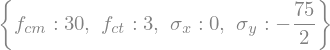

In [65]:
test_param = {sigma_x:0, f_ct:3, f_cm:30}
sigma_y_param = sigma_y_ct_at_tau_zero.subs(test_param)
test_param.update({sigma_y: sigma_y_param})
test_param

Verify that the shear stress is zero for the identified set of parameters

In [66]:
tau_fps_ct_solved.subs(test_param)

Since $\sigma_x$ was set equal to zero and $\tau$ is zero implicitly, the only way how to satisfy the Kupfer criterion is 
$$
\sigma_y = - 5/4 f_\mathrm{cc} = -37.5
$$

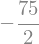

In [67]:
sigma_1_xy.subs(tau_fps, tau_fps_ct_solved).subs(test_param)

Note that $\sigma_2$ is then equal to $\sigma_x$ and $\sigma_1 = \sigma_y$

In [68]:
sigma_2_xy.subs(tau_fps, tau_fps_ct_solved).subs(test_param)

In [70]:
theta.subs(test_param).subs(tau_fps,0)

## Verification 2: Test the solution for values with $\sigma_1 = 0$ 

Similarly to the case $\tau = 0$ let us now test the case in which the principal compressive stress 
component is zero, i.e. $\sigma_1 = 0$. This case is particularly important to define the transition between tension-compression and tension-tension regime within the Kupfer condition.

To derive the relation between $\sigma_y$ and $\sigma_x$ assuming $\sigma_1 = 0$, let us first substitute the solved function $\tau(\sigma_x, \sigma_y)$ into the function $\sigma_1(\sigma_x, \sigma_y, \tau)$

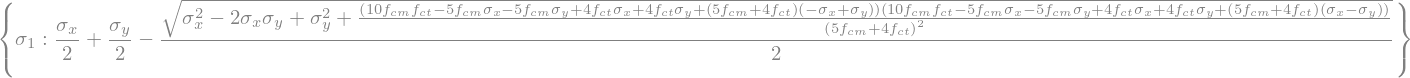

In [71]:
sigma_1_ct_xy_solved = sigma_1_xy.subs(tau_fps, tau_fps_ct_solved)
{sigma_1 : sigma_1_ct_xy_solved}

By this expression to be zero we can obtain the desired link 
$$
\left. \sigma_1(\sigma_x, \sigma_y) \right|_{f=0}= 0 \; \implies \;
\left. \sigma_y(\sigma_x) \right|_{\sigma_1 = 0}
$$

In [72]:
sigma_y_at_sigma_1_zero = sp.solve(sigma_1_ct_xy_solved,sigma_y)[0]
{sigma_y: sigma_y_at_sigma_1_zero}

Let us now use this link to identify a state with $\sigma_1 = 0$
Given the global stress component $\sigma_x = 0$
and the strength parameters $f_\mathrm{ct} = 3, f_\mathrm{cc} = 30$
let us derive the corresponding $\sigma_y$ and insert it into the `test_param` dictionary

In [87]:
test_param = {sigma_x:3, f_ct:3, f_cm:30}
sigma_y_param = sigma_y_at_sigma_1_zero.subs(test_param)
test_param.update({sigma_y: sigma_y_param})
test_param

Note that we set $\sigma_x = f_\mathrm{ct}$. This means that the only way to satisfy the requirement of simultaneous yielding and uniaxial stress state is the zero value of $\tau$

In [88]:
tau_fps_ct_solved.subs(test_param)

The zero value of $\sigma_1$ is implicitly fulfilled, so that we verify

In [89]:
sigma_1_xy.subs(tau_fps, tau_fps_ct_solved).subs(test_param)

Finally, the tensile component of the principal stress is equal to the specified the tensile yield limit $f_\mathrm{ct}$, i.e. $\sigma_2 = \sigma_x$

In [90]:
sigma_2_xy.subs(tau_fps, tau_fps_ct_solved).subs(test_param)

In [91]:
theta.subs(test_param).subs(tau_fps,0)

## Verification 3 - crack parallel stress

Is there a configuration at which both $\sigma_x$ and $\sigma_y$ are positive and $\sigma_1$, representing the crack parallel stress, is negative?

In [29]:
sp.solve(sigma_1_xy.subs(tau_fps, tau_fps_ct_solved), sigma_y)[0]

This means that to obtain a negative $\sigma_1$ the condition 
$$\sigma_y < f_\mathrm{ct} - \sigma_x$$
must hold. Thus, in an extreme case $\sigma_x = 0$, $\sigma_y$ must be at most $-f_\mathrm{ct}$ to obtain a negative $\sigma_1$

# Plot diagrams

The two symbolic tests defined above are now reproduced using numerical evaluation 
over a relevant range of parameters

In [30]:
get_tau = sp.lambdify(params, tau_fps_ct_solved, 'numpy')
get_sigma_y_ct_at_tau_zero = sp.lambdify(params, sigma_y_ct_at_tau_zero, 'numpy')
get_sigma_y_at_sigma_1_zero = sp.lambdify(params, sigma_y_at_sigma_1_zero, 'numpy')
get_theta = sp.lambdify(params, theta, 'numpy')
get_sigma_1 = sp.lambdify(params, sigma_1_ct_xy_solved, 'numpy' )
get_sigma_2 = sp.lambdify(params, sigma_2_xy.subs(tau_fps, tau_fps_ct_solved), 'numpy' )

In [92]:
get_sigma_y_ct_at_tau_zero(0,0,3,30)

In [93]:
get_sigma_y_at_sigma_1_zero(0,5,3,30)

In [94]:
get_theta(0,0,3,30)

In [41]:
fig, ax_theta = plt.subplots(1,1)
ax_tau = ax_theta.twinx()
fig.canvas.header_visible=False
sigma_x_range = np.linspace(3,0,100)
sigma_y_range = get_sigma_y_at_sigma_1_zero(sigma_x_range,0,3,30)
ax_theta.plot(sigma_x_range, get_theta(sigma_x_range, sigma_y_range, 3, 30))
ax_theta.set_xlabel(r'$\sigma_x$ [MPa]'); ax_theta.set_ylabel(r'$\theta$ [rad]');
ax_tau.plot(sigma_x_range, get_tau(sigma_x_range, sigma_y_range, 3, 30), color='red', label=r'$\tau$')
ax_tau.set_ylabel(r'$\tau$ [MPa]');
ax_tau.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<lambdifygenerated-5>:2: RuntimeWarning: invalid value encountered in true_divide
  return (arctan(sqrt((10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(-sigma_x + sigma_y))*(10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(sigma_x - sigma_y))/(5*f_cm + 4*f_ct)**2)/(sigma_x - sigma_y + sqrt(sigma_x**2 - 2*sigma_x*sigma_y + sigma_y**2 + (10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(-sigma_x + sigma_y))*(10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(sigma_x - sigma_y))/(5*f_cm + 4*f_ct)**2))))


In [95]:
sigma_x_range = np.linspace(-30,3,40)
sigma_y_range = np.linspace(-30,3,40)
sx, sy = np.meshgrid(sigma_x_range, sigma_y_range)
theta_xy = get_theta(sx, sy, 3, 30)
sigma_1_xy = get_sigma_1(sx, sy, 3, 30)
sigma_2_xy = get_sigma_2(sx, sy, 3, 30)
tau_xy = get_tau(sx, sy, 3, 30)

<lambdifygenerated-5>:2: RuntimeWarning: invalid value encountered in sqrt
  return (arctan(sqrt((10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(-sigma_x + sigma_y))*(10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(sigma_x - sigma_y))/(5*f_cm + 4*f_ct)**2)/(sigma_x - sigma_y + sqrt(sigma_x**2 - 2*sigma_x*sigma_y + sigma_y**2 + (10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(-sigma_x + sigma_y))*(10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(sigma_x - sigma_y))/(5*f_cm + 4*f_ct)**2))))
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in sqrt
  return ((1/2)*sqrt((10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f_ct*sigma_y + (5*f_cm + 4*f_ct)*(-sigma_x + sigma_y))*(10*f_cm*f_ct - 5*f_cm*sigma_x - 5*f_cm*sigma_y + 4*f_ct*sigma_x + 4*f

In [96]:
fig = plt.figure()
ax_theta = fig.gca(projection='3d')
fig.canvas.header_visible=False
ax_theta.contour(sx, sy, sigma_1_xy)
ax_theta.plot_surface(sx, sy, sigma_1_xy, color='red',
                       #linewidth=0, antialiased=False)
                       alpha=.6, linewidth=5,
                       #cmap=cm.gist_earth,antialiased=False, 
                        shade=False,rstride=1, cstride=1)
ax_theta.contour(sx, sy, sigma_2_xy)
ax_theta.plot_surface(sx, sy, sigma_2_xy, color='blue',
                       #linewidth=0, antialiased=False)
                       alpha=.6, linewidth=5,
                       #cmap=cm.gist_earth,antialiased=False, 
                        shade=False,rstride=1, cstride=1)
ax_theta.contour(sx, sy, tau_xy)
ax_theta.plot_surface(sx, sy, tau_xy, color='orange',
                       #linewidth=0, antialiased=False)
                       alpha=.6, linewidth=5,
                       #cmap=cm.gist_earth,antialiased=False, 
                        shade=False,rstride=1, cstride=1)
ax_theta.set_xlabel(r'$\sigma_x$ [MPa]'); 
ax_theta.set_ylabel(r'$\sigma_y$ [MPa]'); 
ax_theta.set_zlabel(r'$\sigma_1, \sigma_2, \tau$ [MPa]');

# ax_tau.plot(sigma_x_range, get_tau(sx, sy, 3, 30), color='red', label=r'$\tau$')
# ax_tau.set_ylabel(r'$\tau$ [MPa]');
# ax_tau.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-96-f4d828c017e0>:17: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax_theta.plot_surface(sx, sy, tau_xy, color='orange',


In [97]:
fig = plt.figure()
ax_theta = fig.gca(projection='3d')
fig.canvas.header_visible=False
ax_theta.plot_surface(theta_xy, sy, sx, color='green',
                       #linewidth=0, antialiased=False)
                       alpha=.6, linewidth=5,
                       #cmap=cm.gist_earth,antialiased=False, 
                        shade=False,rstride=1, cstride=1)
ax_theta.set_zlabel(r'$\sigma_x$ [MPa]'); 
ax_theta.set_ylabel(r'$\sigma_y$ [MPa]'); 
ax_theta.set_xlabel(r'$\theta$ [rad]');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [98]:
fig = plt.figure()
ax_theta = fig.gca(projection='3d')
fig.canvas.header_visible=False
ax_theta.plot_surface(theta_xy, sy, tau_xy, color='green',
                       #linewidth=0, antialiased=False)
                       alpha=.6, linewidth=5,
                       #cmap=cm.gist_earth,antialiased=False, 
                        shade=False,rstride=1, cstride=1)
ax_theta.set_zlabel(r'$\tau$ [MPa]'); 
ax_theta.set_ylabel(r'$\sigma_y$ [MPa]'); 
ax_theta.set_xlabel(r'$\theta$ [rad]');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-98-fe0739077f4b>:4: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax_theta.plot_surface(theta_xy, sy, tau_xy, color='green',


# Update the description below

The consequence of using the Kupfer criterion for the determination of the shear stress at the crack tip is that the currently used evaluation of the critical strain cannot be calculated as 
$$
w_\mathrm{cr} = \frac{1}{E_\mathrm{cr}} \sigma_2 L_\mathrm{c}
$$
as done so far. The question is, if the currently used criterion 
on the principle stress direction could be modified to search for a consistent
value of the shear stress at the crack tip within the stress tensor. 
Then, $w_\mathrm{cr}$ could be expressed in terms of the stress state 
$$
 \varepsilon_{ab} = C_{abcd} \sigma_{cd} 
$$
The crack opening would be obtained as the principle strain distributed over a predefined length $L_\mathrm{c}$.

$$
\varepsilon_{12} = P_{ab} \varepsilon_{bc} P_{cd}
$$

$$
w_\mathrm{cr} = \varepsilon_{2} L_\mathrm{c}
$$

# Implementation 

 - Evaluate $\tau_\mathrm{fps}$ using the bi-axial stress envelope `crack_tip_stress/orientation`
 - Access the values of `f_t` and `f_c`
 - Control the w_cr in each iteration

## Provide an alternative model component for `crack_tip_shear_stress`.

- `CrackTipShearStressCSE`
- `CrackTipShearStressBAC`